In [8]:
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib as mpl
from scipy.interpolate import griddata 
import warnings
import os
import numpy as np
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
warnings.filterwarnings('ignore')
from myTools import myInfo
from myTrend import myfitting2d_sttcs,myRegress3d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib as mpl
# mpl.use('agg')

### ======================================================================
npth='J:/ERA5_VVEL_zonal/ERA5_VVEL_GLOBAl_zonalavg.nc'

sig_pth='C:/Users/shjo/OneDrive/mySO/mySignals/'

wpth='C:/Users/shjo/OneDrive/mySO/Regression_H/zonal/'

index='MEI'
varnm='Vwind'
t_rng=['1993-01', '2017-12']
lat_rng=[-75,60]; lon_rng=[0,360]

In [9]:
### =======================================================================
with open(sig_pth+'my'+index+'.pkl', 'rb') as f:
    data = pickle.load(f)
Esig9317=data.mean(axis=1).loc[t_rng[0]:t_rng[-1]].values

### Preparation ============================================================
wpth=wpth+varnm+'_'+str(t_rng[0][:4])+'_'+str(t_rng[-1][:4])+'_'+\
    str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+'_'+str(lon_rng[0])+\
        'E'+str(lon_rng[-1])+'E'+'_'+'mode'+'/'
wpth=wpth.replace('-','')
try :
    os.mkdir(wpth)
except:
    pass
# loc=sys._getframe().f_code.co_filename
# myInfo(loc,wpth)

myDATA=[npth]

In [10]:

def mStreamFuction(lat,levels,data2D):
    '''
    Meridional StreamFunction
    Inputs --> numpy array
    '''
    N,M=data2D.shape
    myRAD=np.cos(lat*np.pi/180)
    Trigon2D=np.tile(myRAD,[N-1,1])
    g=9.8; pi=np.pi
    r=6378000 #(Earth raidus (m))
    psi=np.zeros([N-1,M])
    
    Del_press=-np.diff(levels) # Equal to --> levels[:-1]-levels[1:]
    Del_press=np.tile(Del_press,(M,1)).T
    
    data2D_M=(data2D[1:,:]+data2D[:-1,:])/2

    V=data2D_M#*Del_press
        
    for i in range(N):
        if i==N-1:
            break
        psi[i]=np.sum( V[i:,:]*Del_press[i:],axis=0 )
    
    SF=2*pi*r*g**(-1)*Trigon2D*psi    
    return SF
    

In [15]:
for i in myDATA: 
    print('!!! Open: '+i+' !!!')
    tmp=xr.open_dataset(i)
    if len(tmp.coords)==3:
        mydata = tmp['v'].loc[dict(latitude=slice(lat_rng[0],lat_rng[-1])\
            ,time=slice(t_rng[0],t_rng[-1]))]

    # mydata=mydata.where(mydata<1000)
    # mydata=mydata.where(mydata>-1000)

    mydata=mydata.fillna(0)
    # mydata=mydata.rolling(time=12,center=True).mean()[6:-5]
    
    latitude = mydata.latitude.values
    levels   = mydata.level.values
    
    lat_m,levels_m=np.meshgrid(latitude,levels[1:])
    time=mydata.time.values
    dta_nm=i.split('/')[-1][:-3].split('_')[0]+' '+varnm+')\n'+\
        str(lon_rng[0])+'~'+str(lon_rng[-1])+'E '+str(time[0])[:4]+' '+str(time[-1])[:4]
    dta_snm=i.split('/')[-1][:-3].split('_')[0]+\
        str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+' '+str(lon_rng[0])+'E'+str(lon_rng[-1])+'E_'+\
            str(time[0])[:4]+' '+str(time[-1])[:4]
    
    dta_snm=dta_snm.replace(' ','_').replace('salt','salinity').replace('-','')
    dta_nm=dta_nm.replace('salt','salinity').replace('-','')
    print(dta_snm)
    print(dta_nm)
    
    #Calculates StreamFunction
    T,M,N=mydata.shape
    mydata_=mydata.values
    mySF=np.zeros([T,M-1,N])
    for n,ii in zip(range(T),mydata_):
        mySF[n]=mStreamFuction(latitude,levels,ii)
        

    slope,intercept,r_value,p_value,std_err,smask=myRegress3d_sttcs(Esig9317,mySF,threshold=0.01)

    

!!! Open: J:/ERA5_VVEL_zonal/ERA5_VVEL_GLOBAl_zonalavg.nc !!!
ERA575S60S_0E360E_1993_2017
ERA5 Vwind)
0~360E 1993 2017


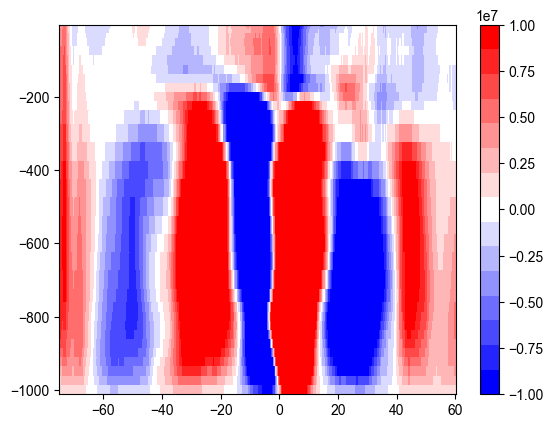

In [20]:
plt.pcolor(lat_m,-levels_m,slope,cmap=plt.get_cmap('bwr',15),vmin=-1*10**7,vmax=10**7)
plt.colorbar()

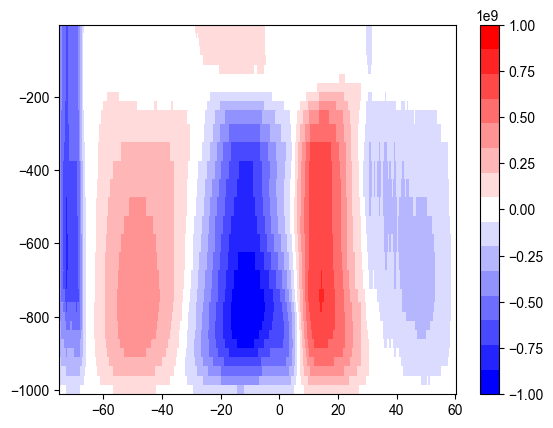

In [21]:
plt.pcolor(lat_m,-levels_m,np.mean(mySF,axis=0),cmap=plt.get_cmap('bwr',15),vmin=-1*10**9,vmax=10**9)
plt.colorbar()